### Main file

In [1]:
import numpy as np 
from tools.srbm import *
from tools.helpers import *
import matplotlib.pyplot as plt

date_str = str(datetime.datetime.now())[0:10]
date_time_str = str(datetime.datetime.now())[0:10]+"_"+str(datetime.datetime.now())[11:16]

In [2]:
Id = create_Id(N_v = N_v, N_c = N_c, n_c_unit = n_c_unit, beta = beta_parameter, n_samples=n_samples)
W, b_v, b_c, b_h = create_rbm_parameters(N_v = N_v, N_c = N_c, N_h = N_h)
mnist_data = load_mnist_data(n_samples = n_samples, min_p = .00001, max_p = .98, binary = True, seed=0)

In [3]:

loc = main(W, b_v, b_c, b_h, Id = Id, dorun = True, monitors = True, mnist_data=mnist_data) # changed from create_Id to Id

Creating equation
Creating Population


WARNING    Removing unsupported flag '-march=native' from compiler flags. [brian2.codegen.cpp_prefs]
INFO       No numerical integration method specified for group 'neurongroup_1', using method 'euler' (took 0.01s, trying other methods took 0.00s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup', using method 'euler' (took 0.01s, trying other methods took 0.00s). [brian2.stateupdaters.base.method_choice]


Train accuracy: 0.085
Test accuracy: 0.12
Train accuracy: 0.13
Test accuracy: 0.139
Train accuracy: 0.105
Test accuracy: 0.098
Train accuracy: 0.095
Test accuracy: 0.112
Train accuracy: 0.09
Test accuracy: 0.08
Train accuracy: 0.105
Test accuracy: 0.097
Train accuracy: 0.105
Test accuracy: 0.097
Train accuracy: 0.09
Test accuracy: 0.105
Train accuracy: 0.12
Test accuracy: 0.13
Train accuracy: 0.095
Test accuracy: 0.105
Train accuracy: 0.15
Test accuracy: 0.155
Train accuracy: 0.15
Test accuracy: 0.152


KeyboardInterrupt: 

In [ ]:
locals().update(loc)

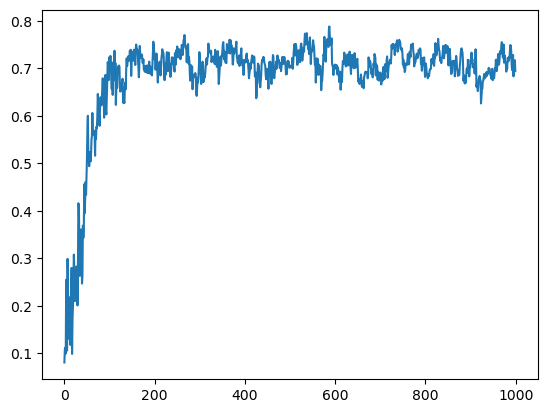

In [ ]:
plot(res_hist_test)
plt.show()

In [ ]:
# Why does beta get replaced by the numpy function??
W = np.array(Srs.w).reshape(N_v+N_c, N_h)*beta_parameter
Wvh=W[:N_v,:]
Wch=W[N_v:,:]
mBv = np.array(Sbv.w)*beta_parameter*tau_rec*bias_input_rate
mBh = np.array(Sbh.w)*beta_parameter*tau_rec*bias_input_rate
b_c = mBv[N_v:(N_v+N_c)]
b_v = mBv[:N_v]
b_h = mBh
mB = np.concatenate([mBv,mBh])

In [ ]:
save_matrices(W, Wvh, Wch, mBv, mBh, b_c, b_v, b_h, mB, date_str, date_time_str)

Matrices saved to output/output/2023-04-17/10-12
